## Image Classification with EMNIST Dataset

### Obtaining the EMNIST Dataset

In [0]:
pip install emnist

(697932, 28, 28) (116323, 28, 28)
LABELED AS: 35
None


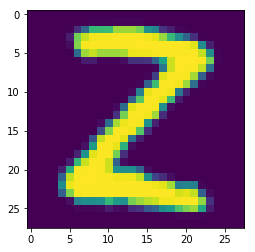

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
# Only use this if using iPython
%matplotlib inline

from emnist import extract_training_samples, extract_test_samples
x_train, y_train = extract_training_samples('byclass')
x_test, y_test   = extract_test_samples('byclass')

print(x_train.shape, x_test.shape)

i = 0
print("LABELED AS:", y_train[i])
plt.imshow(x_train[i])

#print(x_train[0])
image = Image.open("pic1.png")
print(image.show())

### Reshaping the training and test data

In [0]:
# NEW
x_train = x_train.reshape(697932, 28, 28)
y_train = y_train.reshape(697932, 1)
x_test = x_test.reshape(116323, 28, 28)
y_test = y_test.reshape(116323, 1)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')/255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')/255
input_shape = (28, 28, 1)
num_classes = 62

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (697932, 28, 28, 1)
Number of images in x_train 697932
Number of images in x_test 116323


### Making, training and evaluating the model

In [0]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# Loss 0.

# Optimized model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


In [0]:
model.compile(optimizer='adadelta',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, batch_size=128, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
697932/697932 [==============================] - 77s 111us/step - loss: 0.5768 - acc: 0.8114
Epoch 2/10
  5248/697932 [..............................] - ETA: 1:14 - loss: 0.4567 - acc: 0.8436

KeyboardInterrupt: ignored

In [0]:
model.evaluate(x_test, y_test)

# First model
# [0.37821523829298365, 0.8649106367619439]

# Second model
# [0.36202002978185105, 0.8665526164220284]

# Third model with 62 in the second conv2d layer
# [0.3531124924307382, 0.8706188801870653]

In [0]:
image_index = 598
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax(),y_test[image_index])

### Save model for later use

In [0]:
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, "character_detection_model_v3")

# Save JSON config to disk
json_config = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(json_config)
# Save weights to disk
model.save_weights('model_weights.h5')

# Importing a pre trained model
# with tf.Session() as sess:
#   new_saver = tf.train.import_meta_graph('model_name.meta')
#   new_saver.restore(sess, tf.train.latest_checkpoint('./'))

### Transforming the input image to the right format

In [0]:
from PIL import Image, ImageFilter
def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    print(tva)
    return tva

In [0]:
from google.colab import files
uploaded = files.upload()

### Classification

In [0]:
x=[imageprepare('g.PNG')]

newArr=[[0 for d in range(28)] for y in range(28)]
k = 0
for i in range(28):
    for j in range(28):
        newArr[i][j]=x[0][k]
        k=k+1
        
newArr = np.array(newArr)
plt.imshow(newArr.reshape(28, 28),cmap='Greys')
pred = model.predict(newArr.reshape(1, 28, 28, 1))

label = pred.argmax()
if (label <= 9):
  print("Digit:", chr(48+label), "["+str(label)+"]")
elif (label <= 35):
  print("Uppercase:", chr(65+label-10), "["+str(label)+"]")
elif (label <= 62):
  print("Lowercase:", chr(97+label-36), "["+str(label)+"]")